# Gene subset phase and amplitude

mt-Nd1
mt-Nd2
mt-Co1
mt-Co2
mt-Atp8
mt-Atp6
mt-Co3
mt-Nd3
mt-Nd4l
mt-Nd4
mt-Nd5
mt-Nd6
mt-Cytb


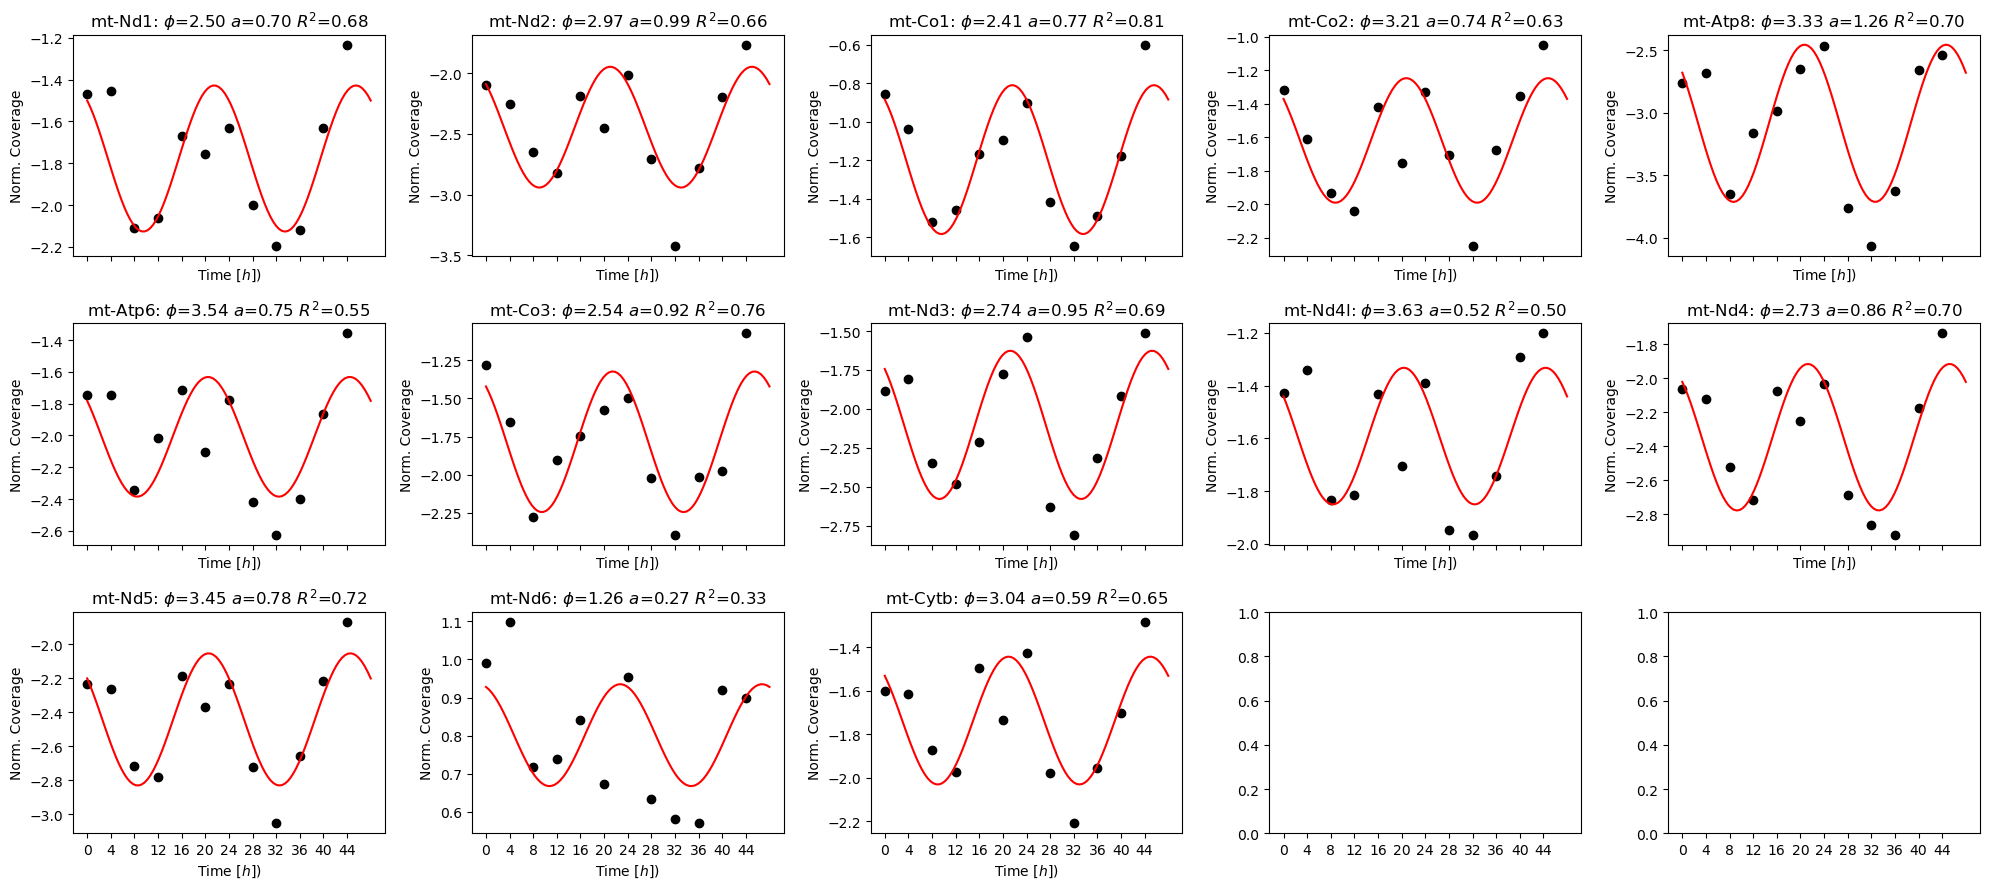

In [229]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig as bw
from scipy.stats import beta

# parameters
bin_size = 100
bw_path = '../results/binned_norm_counts'
phase_path = '../results/phase_amp'
T = np.arange(0,48,4)
Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}
CHR = [f'chr{i}' for i in range(1,23)] + ['chrX','chrY','chrM']

n = 1
P = 24
N = len(T)


# Load bigWigs
f = {}
for t in T:
    sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001'
    f[t] = {}
    for strand in Strands:
        fin = f"{bw_path}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw"
        f[t][strand] = bw.open(fin)

# load gene cycle
gene_phase_amp = pd.read_csv(f'{phase_path}/gene_phase_amp_{bin_size}bp.csv')

my_genes = gene_phase_amp[gene_phase_amp.chr == 'chrM'].gene_name
#my_genes = gene_phase_amp[gene_phase_amp.R2 > 0.9].gene_name

n_cols = 5
n_rows = len(my_genes)//n_cols + 1
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4,n_rows*3), sharex=True)

for i,g in enumerate(my_genes):
    print(g)

    gene = gene_phase_amp.loc[gene_phase_amp.gene_name == g,:]

    gene_start = gene.start.values[0] - (gene.start.values[0] % bin_size)
    gene_end =  gene.end.values[0] + (bin_size - (gene.end.values[0] % bin_size))
    bins = np.arange(gene_start, gene_end+1, bin_size)
    X_bt = pd.DataFrame(np.zeros([len(bins),len(T)]), index=bins, columns=T)
    X_bt.values[:] = np.nan

    # get gene bin-time values
    for t in T:
        intervals = f[t][strand_dict[gene.strand.values[0]]].intervals(gene.chr.values[0],gene.start.values[0],gene.end.values[0])
        
        if intervals is None:
            X_bt.loc[:,t] = np.nan
            continue

        vals = [b[2] for b in intervals]
        starts = [b[0] for b in intervals]
        X_bt.loc[starts,t] = np.array(vals)

    # remove 
    idx_out = np.isnan(X_bt.values).sum(1)/T.shape[0] >= .75

    if not idx_out.all():
        X_bt = X_bt.loc[~idx_out,:]
        X_bt = X_bt.fillna(0)

        # log transform, add pseudo counts and average gene expression across bins
        X_bt = np.log(X_bt.values + 1/bin_size)

    x = X_bt.mean(axis=0)
    dx = X_bt.std(axis=0)

    # Fourier transform
    f_n = np.sum(x*np.exp(-1j*2*n*np.pi*T/P))
    a_n = 4/N * np.abs(f_n) # *4 ??
    phi_n = np.arctan2(np.imag(f_n),np.real(f_n)) # ?? -im/re ??
    mu = 1/N * np.sum(x)

    # compute fit's R2 and p-value
    x_hat = mu + 0.5 * a_n * np.cos(2 * np.pi / P * T + phi_n)
    sig2_res = np.var(x - x_hat)
    sig2_tot = np.var(x)
    R2 = np.zeros(sig2_res.shape)
    R2[sig2_tot==0] = 0
    R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    if phi_n<0:
        phi_n += np.pi * 2

    # plot
    ax = axes[i//n_cols,i%n_cols]
    #ax.errorbar(T, x, yerr=dx, fmt='o', color='k', ecolor='k', capsize=2, label='Mean $\pm$ std')
    ax.plot(T, x, 'o', color='k', label='Mean')
    x_ = np.linspace(0,48,100)
    ax.plot(x_, mu + 0.5 * a_n * np.cos(2 * np.pi / P * x_ + phi_n), color='r', label='Fourier fit')
    ax.set_title(f'{g}: $\\phi$={phi_n/(2*np.pi)*24:.2f} $a$={a_n:.2f} $R^2$={R2:.2f}')
    ax.set_xlabel(r'Time $[h]$)')
    ax.set_ylabel(r'Norm. Coverage')
    ax.set_xticks(T)


plt.tight_layout()
plt.savefig(f'../results/fig/gene_phase_amp_{bin_size}bp.pdf')


# Mean cycle accros all bins and chromosomes

100
forward
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chrX chrY chrM 
reverse
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chrX chrY chrM 
1000
forward
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chrX chrY chrM 
reverse
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chrX chrY chrM 
10000
forward
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chrX chrY chrM 
reverse
chr1 chr2 chr3 chr4 chr5 chr6 chr7 chr8 chr9 chr10 chr11 chr12 chr13 chr14 chr15 chr16 chr17 chr18 chr19 chrX chrY chrM 


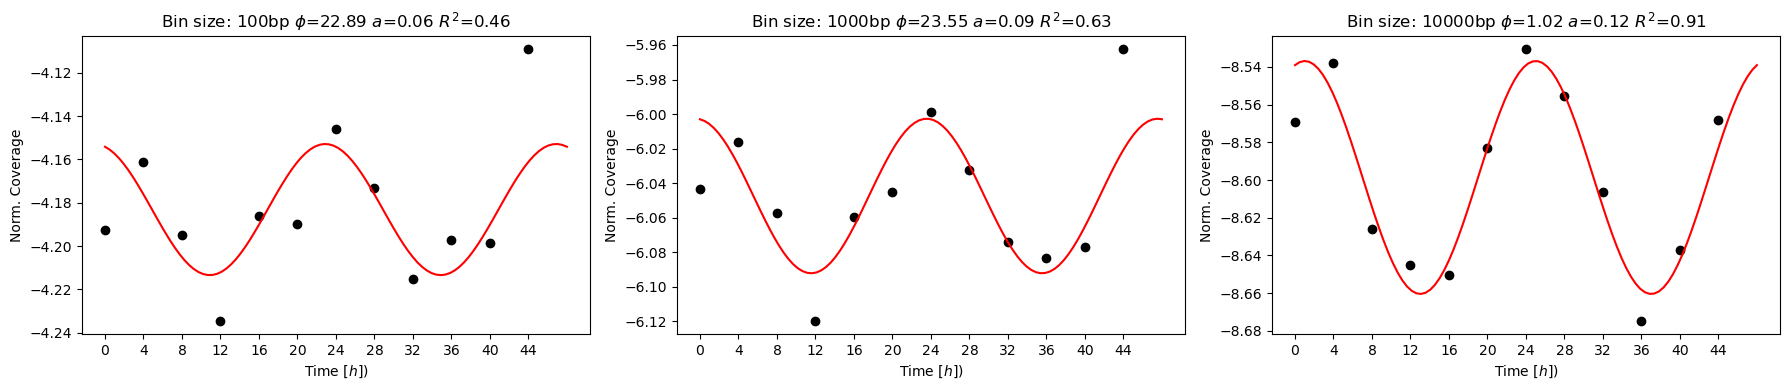

In [57]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyBigWig as bw
from scipy.stats import beta

# parameters
bw_path = '../results/binned_norm_counts'
phase_path = '../results/phase_amp'
T = np.arange(0,48,4)
Strands = ['forward', 'reverse']
strand_dict = {'forward':'+', 'reverse':'-', '+':'forward', '-':'reverse'}
CHR = [f'chr{i+1}' for i in range(19)] + ['chrX','chrY','chrM']
n = 1
P = 24
N = len(T)

Bin_sizes = [100, 1000, 10000]
fig, axes = plt.subplots(1,3, figsize=(3*6,4), sharex=True)
for bin_size, ax in zip(Bin_sizes,axes): 
    print(bin_size)

    # Load bigWigs
    f = {}
    for t in T:
        sample = f'PRO_SEQ_CT{t:02d}_S{t//4+1}_R1_001'
        f[t] = {}
        for strand in Strands:
            fin = f"{bw_path}/{sample}/NormCoverage_3p_{strand}_bin{bin_size}bp.bw"
            f[t][strand] = bw.open(fin)

    X = np.zeros([0,len(T)])
    for strand in Strands:
        print(strand)
        for chr in CHR:
            print(chr, end=' ')
            bins = set()
            for t in T:
                bins = bins.union( set( [b[0] for b in f[t][strand].intervals(chr)] ) )
            bins = list(bins)
            bins.sort()
            
            X_bt = pd.DataFrame(np.zeros([len(bins),len(T)]), index=bins, columns=T)
            X_bt.values[:] = np.nan

            for t in T:
                intervals = f[t][strand].intervals(chr,bins[0],min(bins[-1]+bin_size,f[t][strand].chroms(chr)))
            
                if intervals is None:
                    X_bt.loc[:,t] = np.nan
                    continue

                vals = [b[2] for b in intervals]
                starts = [b[0] for b in intervals]
                X_bt.loc[starts,t] = np.array(vals)

            # remove bins with 75% missing values or more
            idx_out = np.isnan(X_bt.values).sum(1)/T.shape[0] >= .99

            # stack X_bt to X
            if not idx_out.all():
                X_bt = X_bt.loc[~idx_out,:]
                X_bt = X_bt.fillna(0)

                X = np.vstack([X,X_bt.values])
        print()

    # log transform, add pseudo counts
    X = np.log(X + 1/bin_size)

    x = X.mean(axis=0)
    dx = X.std(axis=0)

    # Fourier transform
    omega = 2*np.pi/P*n
    f_n = np.sum(x*np.exp(-1j*omega*T))
    a_n = 4/N * np.abs(f_n) # *4 ??
    phi_n = -np.arctan2(np.imag(f_n),np.real(f_n)) # ?? -im/re ??
    mu = 1/N * np.sum(x)

    # compute fit's R2 and p-value
    x_hat = mu + 0.5 * a_n * np.cos(omega*T - phi_n)
    sig2_res = np.var(x - x_hat)
    sig2_tot = np.var(x)
    R2 = np.zeros(sig2_res.shape)
    R2[sig2_tot==0] = 0
    R2[sig2_tot!=0] = 1 - sig2_res[sig2_tot!=0] / sig2_tot[sig2_tot!=0]
    p = 3
    pval = 1 - beta.cdf(R2, (p - 1) / 2, (N - p) / 2)
    if phi_n<0:
        phi_n += np.pi * 2

    # plot
    #ax.errorbar(T, x, yerr=dx, fmt='o', color='k', ecolor='k', capsize=2, label='Mean $\pm$ std')
    ax.plot(T, x, 'o', color='k', label='Mean')
    x_ = np.linspace(0,48,100)
    ax.plot(x_, mu + 0.5 * a_n * np.cos(omega * x_ - phi_n), color='r', label='Fourier fit')
    ax.set_title(f'Bin size: {bin_size}bp $\\phi$={phi_n/(2*np.pi)*P:.2f} $a$={a_n:.2f} $R^2$={R2:.2f}')
    ax.set_xlabel(r'Time $[h]$)')
    ax.set_ylabel(r'Norm. Coverage')
    ax.set_xticks(T)


plt.tight_layout()
plt.savefig(f'../results/fig/all_chromosomes_phase_amp_{bin_size}bp.pdf')